In [1]:
import sys
sys.path.append("../data/saved_models/")
sys.path.append("../model_scripts/")
sys.path.append("../utils/")
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import fig1_plots

import analysis_rnn as rnn
import analysis_neuro as spk
import basic_analysis as basic
import model_utils
import dim_alignment as dim
from task import generate_batch

from scipy import stats
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance as dist

In [2]:
# file paths
data_folder = f"../data/saved_models/1d_2map/"
save_folder = f"../figures/fig1_plots/"

if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)

save folder exists


In [3]:
# get the model IDs for all saved models
model_IDs = os.listdir(data_folder)

# select example model
ex_id = 0
model_ID = model_IDs[ex_id]

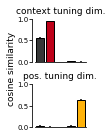

In [4]:
''' Figure 1K alt for supplement '''
f, ax = fig1_plots.plot_k_alt(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}dim_angles_alt.png', dpi=600, bbox_inches='tight')

In [4]:
# get sample rnn data
inputs, outputs, targets = model_utils.sample_rnn_data(data_folder, model_ID)
X, map_targ, pos_targ = model_utils.format_rnn_data(outputs["hidden_states"],\
                                                    targets["map_targets"],\
                                                    targets["pos_targets"])

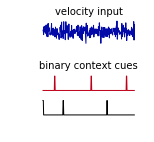

In [5]:
''' Figure 1E: inputs '''
f, gs = fig1_plots.plot_e(inputs["inp_vel"],\
                          inputs["inp_remaps"])
plt.show()
f.savefig(f'{save_folder}inputs.png', dpi=600, bbox_inches='tight')

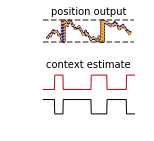

In [6]:
''' Figure 1F: outputs'''
f, gs = fig1_plots.plot_f(targets["pos_targets"],\
                          outputs["pos_outputs"],\
                          outputs["map_logits"])
plt.show()
f.savefig(f'{save_folder}outputs.png', dpi=600, bbox_inches='tight')

mean +/- standard error of the mean:
position loss: 0.0105 +/- 0.000375
context loss: 0.00179 +/- 3.18e-05


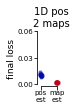

In [7]:
''' summary performance across models '''
f, ax = fig1_plots.plot_supp_1(data_folder, model_IDs)
ax.set_title('1D pos\n2 maps', fontsize=10, pad=5)
plt.show()

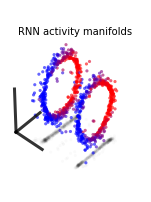

In [8]:
''' Figure 1H: aligned ring manifolds '''
f, ax = fig1_plots.plot_h(X, pos_targ)
plt.show()
f.savefig(f'{save_folder}manifolds.png', dpi=600, bbox_inches='tight')

mean alignment = 0.6
sem misalignment = 0.0093


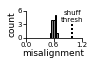

In [9]:
''' Figure 1I (or supp?): summary of ring alignment '''
f, ax = fig1_plots.plot_j(data_folder, model_IDs)
f.savefig(f'{save_folder}alignment.png', dpi=600, bbox_inches='tight')
plt.show()

In [5]:
''' are the position outputs orthogonal? '''
n_models = len(model_IDs)

pos_out_angle = np.zeros(n_models)
for i, m_id in enumerate(model_IDs):
    # get the model weights
    model, _, _ = rnn.load_model_params(data_folder, model_ID)
    pos_out_w = model.readout_layer_pos.weight
    pos_out_w = pos_out_w.detach().numpy().T
    
    # angle between output weights
    pos_out_angle[i] = dim.cosine_sim(pos_out_w[:, 0], pos_out_w[:, 1])
    
avg_angle = np.rad2deg(np.arccos(np.abs(np.mean(pos_out_angle))))
print(f'the avg angle between position outputs is {int(avg_angle)} deg.')

the avg angle between position outputs is 88 deg.


In [135]:
def compute_remap_vectors(data_folder, m_id, \
                          n_pos_bins=50, n_shuffle=100):
    # get the rnn data
    model, _, _ = rnn.load_model_params(data_folder, m_id)
    inputs, outputs, targets = rnn.sample_rnn_data(data_folder, m_id)
    X, map_targ, pos_targ = format_rnn_data(outputs["hidden_states"],\
                                            targets["map_targets"],\
                                            targets["pos_targets"])
    
    # split by context
    X0 = X[map_targ==0]
    X1 = X[map_targ==1]
    pos0 = pos_targ[map_targ==0]
    pos1 = pos_targ[map_targ==1]

    # get the position-binned firing rates
    tc_0, _ = basic.tuning_curve_1d(X0, pos0, n_pos_bins=n_pos_bins)
    tc_1, _ = basic.tuning_curve_1d(X1, pos1, n_pos_bins=n_pos_bins)

    # find the remapping dimension
    v = rnn.remapping_dim(tc_0, tc_1)

    # find each psi_p
    xi_p = tc_0 - tc_1
    
    # is xi_p orthog. to the position output weights?
    pos_out_w = model.readout_layer_pos.weight
    W = pos_out_w.detach().numpy().T
    Wxi = (xi_p @ W) / np.linalg.norm(xi_p)
    avg_Wxi = np.mean(Wxi, axis=1)

    # get the difference
    d_xi = np.linalg.norm(v - xi_p, axis=1) / np.linalg.norm(v)
    
    # compute the shuffles
    d_shuff_null = np.zeros([n_shuffle, n_pos_bins])
    d_shuff_rotate = np.zeros([n_shuffle, n_pos_bins])
    for k in range(n_shuffle):
        # shuffle 1: randomly chosen from the nullspace
        z_null = shuff_xi_nullspace(xi_p, W)
        d_shuff_null[k] = np.linalg.norm(v - z_null, axis=1) / np.linalg.norm(v)
        
        # shuffle 2: randomly rotate tc_1
        z_rotate = shuff_xi_rotate(tc_0, tc_1, W)
        d_shuff_rotate[k] = np.linalg.norm(v - z_rotate, axis=1) / np.linalg.norm(v)
        
    return avg_Wxi, d_xi, d_shuff_null, d_shuff_rotate

In [92]:
def shuff_xi_nullspace(xi_p, W):
    n_pos_bins, n_units = xi_p.shape
    
    # find random vectors
    z = np.random.randn(n_units, n_pos_bins)

    # get the portion in the nullspace
    proj = W @ np.linalg.inv(W.T @ W) @ W.T
    z_null = z - proj @ z

    # normalize to each pos bin
    z_null = (z_null / np.linalg.norm(z_null)) * np.linalg.norm(xi_p, axis=1)
    
    return z_null.T

In [93]:
def shuff_xi_rotate(tc_0, tc_1, W):
    n_pos_bins, n_units = tc_1.shape
    
    # randomly rotate tc_1 in the nullspace of W
    P = scipy.linalg.null_space(W.T)
    Q = np.linalg.qr(np.random.randn(P.shape[1], P.shape[1]))[0]
    tc_1_rotate = tc_1 @ (P @ Q @ P.T)
    
    # find random vectors
    return tc_0 - tc_1_rotate

In [136]:
'''
Another way to compute alignment:
let v = remapping vector
find each xi_p and take: norm(v - xi_p) / norm(v)
plot histogram
'''
from model_utils import sample_rnn_data, format_rnn_data
n_pos_bins = 50
n_shuffle = 100

# data params
n_models = len(model_IDs)
n_units = X.shape[1]

# to store the results
d_xi = np.zeros([n_models, n_pos_bins])
avg_Wxi = np.zeros([n_models, n_pos_bins])

# to store the shuffles
d_shuff_null = np.zeros([n_models, n_shuffle, n_pos_bins])
d_shuff_rotate = np.zeros([n_models, n_shuffle, n_pos_bins])
# compute for all models
for i, m_id in enumerate(model_IDs):
    print(f'model {i + 1} of {n_models}')
    
    all_vector_results= compute_remap_vectors(data_folder, m_id, \
                                              n_pos_bins=n_pos_bins, n_shuffle=n_shuffle)  
    avg_Wxi[i], d_xi[i], d_shuff_null[i], d_shuff_rotate[i] = all_vector_results

model 1 of 15
model 2 of 15
model 3 of 15
model 4 of 15
model 5 of 15
model 6 of 15
model 7 of 15
model 8 of 15
model 9 of 15
model 10 of 15
model 11 of 15
model 12 of 15
model 13 of 15
model 14 of 15
model 15 of 15


In [95]:
print(f'mean W * xi = {np.mean(avg_Wxi):.3}')
print(f's.e.m. W * xi = {stats.sem(avg_Wxi.ravel()):.3}')

mean W * xi = 9.23e-06
s.e.m. W * xi = 1.63e-05


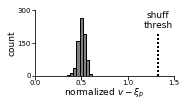

In [228]:
''' supp fig: true remapping vectors vs. ideal and shuffles '''
# font sizes
title_size = 10
axis_label = 9
tick_label = 7

# fig params 
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.2))
BAR_LW = 1
THRESH_LW = 2

# plot the data
ax.hist(d_xi.ravel(), np.linspace(0.0, 1.0, 30),\
        color="gray", lw=BAR_LW, edgecolor="k")
ax.set_xlabel("normalized $v - \\xi_p$", fontsize=axis_label, labelpad=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plot the shuffle thresholds
shuff_thresh = np.percentile(d_shuff_rotate.ravel(), 2.5)
ax.vlines(shuff_thresh, 0, 200, linestyles=(200, [1, 1]), 
          lw=THRESH_LW, color='k')

# labels and lims
ax.set_xlim([0, 1.5])
ax.set_xticks(np.arange(0, 1.6, 0.5))
ax.set_yticks([0, 150, 300])
ax.tick_params(which='major', labelsize=tick_label, pad=0.5)
ax.spines["left"].set_bounds(0, 300)
ax.set_ylabel("count", fontsize=axis_label, labelpad=1)
ax.text(shuff_thresh, 220, "shuff\nthresh",
        fontsize=axis_label, horizontalalignment='center')

f.savefig(f'{save_folder}remap_vectors.png', dpi=600, bbox_inches='tight')
plt.show()

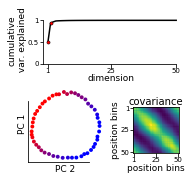

In [254]:
''' supp fig: the remapping dimensions lie in a 2D subspace '''
from matplotlib import gridspec
from plot_utils import simple_cmap, ring_colormap

# data params
n_dims = np.min(xi_p.shape)
spacer = n_dims / 50
pos_bins = np.linspace(0, 2*np.pi, n_dims)

# PCA on remap vectors
xi_bar = xi_p - np.mean(xi_p, axis=0)
pca = PCA().fit(xi_bar)
var = pca.explained_variance_
total_var = np.sum(var)
pct_var = (var / total_var)
cum_var = np.cumsum(pct_var)
x_, y_ = PCA(n_components=2).fit_transform(xi_bar).T

# fig params
gs = gridspec.GridSpec(6, 5, hspace=2, wspace=0)
f = plt.figure(figsize=(2.1, 2.1))
PC_LW = 1.5
DOT_SIZE = 10

# plot the cumulative variance explained
# ax0 = plt.subplot(gs[:2, 1:])
ax0 = plt.axes([0.1, 0.65, 0.9, 0.3])
ax0.plot(np.arange(n_dims) + 1, cum_var, c='k', lw=PC_LW, zorder=0)
ax0.scatter(np.arange(2) + 1,
            cum_var[:2],
            facecolors='r', edgecolors='k',
            s=DOT_SIZE, lw=0.5, zorder=1)
ax0.set_ylim(0, 1.1)

# ticks and labels
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['left'].set_bounds(0, 1)
ax0.spines['bottom'].set_bounds(-spacer, n_dims)
ax0.tick_params(which='major', labelsize=tick_label, pad=0.5)
ax0.set_xlim((-spacer, n_dims+spacer))
ax0.set_xticks([1, n_dims/2, n_dims])
ax0.set_ylim((0, 1.05))
ax0.set_yticks([0, 0.5, 1])
ax0.set_yticklabels([0, 0.5, 1])
ax0.set_xlabel('dimension', fontsize=axis_label, labelpad=0)
ax0.set_ylabel('cumulative\n var. explained', 
               fontsize=axis_label, labelpad=1)

# plot the remap vectors against the first 2 PCs
# ax1 = plt.subplot(gs[3:, :2])
ax1 = plt.axes([0, 0, 0.5, 0.5])
ax1.scatter(x_, y_,
            c=pos_bins, cmap=ring_colormap(),
            alpha=1, lw=0, s=DOT_SIZE*1.5)

# ticks and labels
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelbottom=False, labelleft=False,
                which='major', labelsize=tick_label, pad=0.5)
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()
ax1.set_xlim((xlims[0], 1.6))
ax1.set_ylim((ylims[0], 1.6))
ax1.spines['bottom'].set_bounds(xlims[0], 1)
ax1.spines['left'].set_bounds(ylims[0], 1)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('PC 2', fontsize=axis_label, labelpad=3)
ax1.set_ylabel('PC 1', fontsize=axis_label, labelpad=1) 

# plot the covariance
# ax2 = plt.subplot(gs[3:, 3:])
ax2 = plt.axes([0.7, 0.06, 0.3, 0.3])
cov_xi = xi_p @ xi_p.T
cov_xi = (cov_xi - np.min(cov_xi)) / np.max(cov_xi - np.min(cov_xi))
ax2.imshow(cov_xi, clim=[0, 1], 
           aspect='auto', cmap='viridis')

# ticks and labels
ax2.tick_params(which='major', labelsize=tick_label, pad=0.5)
ax2.set_xticks([0, (n_dims/2) - 1, n_dims-1])
ax2.set_yticks([0, (n_dims/2) - 1, n_dims-1])
ax2.set_xticklabels([1, n_dims//2, n_dims])
ax2.set_yticklabels([1, n_dims//2, n_dims])
ax2.set_xlabel('position bins', fontsize=axis_label, labelpad=1)
ax2.set_ylabel('position bins', fontsize=axis_label, labelpad=1)
ax2.set_title('covariance', fontsize=title_size, pad=3)

f.savefig(f'{save_folder}remap_dims.png', dpi=600, bbox_inches='tight')
plt.show()

In [195]:
''' is the 2D subspace aligned with v? '''
from dim_alignment import proj_aB

pca = PCA(n_components=2).fit(xi_bar)
remap_subspace = pca.components_.T
angle = np.abs(proj_aB(v, remap_subspace))
angle

0.028969032802357457

on average, 3 PCs explain 54.71% of the variance
on average, 12 PCs explain 90.07% of the variance


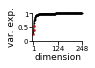

In [10]:
''' Figure 1J: summary of dimensionality '''
f, axes = fig1_plots.plot_i(data_folder, model_IDs,
                            top_num=3, top_num_1=2)
plt.show()
f.savefig(f'{save_folder}PCs_all.png', dpi=600, bbox_inches='tight')

630 total track traversals
59.0 total remapping events


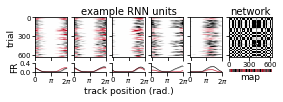

In [5]:
''' plot figure 1G: RNN single unit examples & network similarity '''
f, gs = fig1_plots.plot_g(data_folder, model_IDs[ex_id])
plt.show()
f.savefig(f'{save_folder}ex_tuning_similarity.png', dpi=600, bbox_inches='tight')

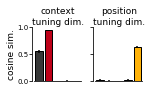

In [4]:
''' Figure 1K: alignment to remapping dim and position subspace '''
f, ax = fig1_plots.plot_k(data_folder, model_IDs)
plt.show()
f.savefig(f'{save_folder}dim_angles.png', dpi=600, bbox_inches='tight')

In [ ]:
''' 
Remaining Qs:
- Are the position dims orthogonal?
    compute this for the pos outputs
- Find the vector v between each position bin across maps and show that they are equal
'''

In [13]:
''' Figure 2F: fixed points on ring manifolds 
this goes somewhere else
'''
# load the fixed points
fixed_pts_np = np.load(f"{base}/saved_models/{model_ID}/states_fixed_pt.npy")
fixed_pts = torch.from_numpy(fixed_pts_np)

# calculate the velocity at each fixed/slow point
num_batch = fixed_pts.shape[0]
num_maps = task_params["num_maps"]
inp_vel = torch.zeros(num_batch, 1)
inp_remaps = torch.zeros(num_batch, num_maps)

X1 = fixed_pts
X2 = model.one_step(fixed_pts, inp_vel, inp_remaps)
X1 = X1.detach().numpy()
X2 = X2.detach().numpy()

vels = np.asarray([])
for x1, x2 in zip(X1, X2): 
    vel = np.sum((x1 - x2)**2)
    vels = np.append(vels, vel)

NameError: name 'base' is not defined

In [ ]:
# filter out points where the velocity is too great
thresh = 0.005
sort_idx = np.argsort(vels)
f, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.scatter(np.arange(vels.shape[0]),
           vels[sort_idx[::-1]], 
           c='k', s=15,
           zorder=0)
xlims = ax.get_xlim()
ax.hlines(thresh, xlims[0], xlims[1],
          linestyles='dotted', colors='r',
          zorder=1, label='thresh'
         )

ax.set_xlim(xlims)
ax.set_ylim(-0.001, 0.02)
ax.set_ylabel('velocity')
ax.set_xlabel('fixed point')
ax.tick_params(which='major', labelsize=8, pad=1)
ax.legend()

plt.show()

In [ ]:
print(f'filtered out {np.sum(vels > thresh)} slow points with velocity > {thresh}')
fixed_pts = fixed_pts[vels < thresh]
fixed_pts_np = fixed_pts_np[vels < thresh]

In [ ]:
f, ax = fig_plots.plot_fig2f(X, fixed_pts, pos_targ)

ax.set_title('')

plt.show()
f.savefig(f'{save_folder}fixed_pts.png', dpi=600, bbox_inches='tight')